[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# How to Train YOLOv12 Object Detection on a Custom Dataset

---

[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/roboflow-ai/notebooks/blob/main/notebooks/train-yolov12-object-detection-model.ipynb)
[![arXiv](https://img.shields.io/badge/arXiv-2502.12524-b31b1b.svg)](https://arxiv.org/abs/2502.12524)
[![Roboflow](https://raw.githubusercontent.com/roboflow-ai/notebooks/main/assets/badges/roboflow-blogpost.svg)](https://blog.roboflow.com/train-yolov12-model)
[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/sunsmarterjie/yolov12)

[YOLOv12](https://github.com/sunsmarterjie/yolov12) is a newly proposed attention-centric variant of the YOLO family that focuses on incorporating efficient attention mechanisms into the backbone while preserving real-time performance. Instead of relying heavily on CNN-based architectures like its predecessors, YOLOv12 introduces a simple yet powerful “area attention” module, which strategically partitions the feature map to reduce the quadratic complexity of full self-attention. It also adopts residual efficient layer aggregation networks (R-ELAN) to enhance feature aggregation and training stability, especially for larger models. These innovations, together with refinements such as scaled residual connections and a reduced MLP ratio, enable YOLOv12 to harness the benefits of attention (e.g., better global context modeling) without sacrificing speed.

![yolov12-area-attention](https://media.roboflow.com/notebooks/examples/yolov12-area-attention.png)

Compared to prior YOLO iterations (e.g., YOLOv10, YOLOv11, and YOLOv8), YOLOv12 achieves higher detection accuracy with competitive or faster inference times across all model scales. Its five sizes—N, S, M, L, and X—range from 2.6M to 59.1M parameters, striking a strong accuracy–speed balance. For instance, the smallest YOLOv12-N surpasses other “nano” models by over 1% mAP with latency around 1.6 ms on a T4 GPU, and the largest YOLOv12-X achieves 55.2% mAP, comfortably outscoring comparable real-time detectors such as RT-DETR and YOLOv11-X . By matching or exceeding state-of-the-art accuracy while remaining fast, YOLOv12 represents a notable step forward for attention-based real-time object detection.

![yolov12-metrics](https://storage.googleapis.com/com-roboflow-marketing/notebooks/examples/yolov12-metrics.png)

## Environment setup

### Configure your API keys

To fine-tune YOLOv12, you need to provide your Roboflow API key. Follow these steps:

- Go to your [`Roboflow Settings`](https://app.roboflow.com/settings/api) page. Click `Copy`. This will place your private key in the clipboard.
- In Colab, go to the left pane and click on `Secrets` (🔑). Store Roboflow API Key under the name `ROBOFLOW_API_KEY`.

In [2]:
import os
from google.colab import userdata

os.environ["ROBOFLOW_API_KEY"] = userdata.get("ROBOFLOW_API_KEY")

### Check GPU availability

**NOTE:** **YOLOv12 leverages FlashAttention to speed up attention-based computations, but this feature requires an Nvidia GPU built on the Ampere architecture or newer—for example, GPUs like the RTX 3090, RTX 3080, or even the Nvidia L4 meet this requirement.**

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [3]:
!nvidia-smi

Mon Jun 16 11:32:05 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   68C    P8             18W /   72W |       3MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [4]:
import os
HOME = os.getcwd()
print(HOME)

/content


### Install dependencies

**NOTE:** Currently, YOLOv12 does not have its own PyPI package, so we install it directly from GitHub while also adding roboflow (to conveniently pull datasets from the Roboflow Universe), supervision (to visualize inference results and benchmark the model’s performance), and flash-attn (to accelerate attention-based computations via optimized CUDA kernels).

In [5]:
!pip install -q git+https://github.com/sunsmarterjie/yolov12.git roboflow supervision flash-attn

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


### Download example data

Let's download an image we can use for YOLOv12 inference. Feel free to drag and drop your own images into the Files tab on the left-hand side of Google Colab, then reference their filenames in your code for a custom inference demo.

In [6]:
!wget https://media.roboflow.com/notebooks/examples/dog.jpeg

--2025-06-16 11:32:18--  https://media.roboflow.com/notebooks/examples/dog.jpeg
Resolving media.roboflow.com (media.roboflow.com)... 34.110.133.209
Connecting to media.roboflow.com (media.roboflow.com)|34.110.133.209|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106055 (104K) [image/jpeg]
Saving to: ‘dog.jpeg.1’

dog.jpeg.1          100%[===================>] 103.57K  --.-KB/s    in 0.001s  

2025-06-16 11:32:18 (130 MB/s) - ‘dog.jpeg.1’ saved [106055/106055]



## Run inference

In the example, we're using the `yolov12l.pt` model, but you can experiment with different model sizes by simply swapping out the model name during initialization. Options include `yolov12n.pt`, `yolov12s.pt`, `yolov12m.pt`, `yolov12l.pt`, and `yolov12x.pt`.

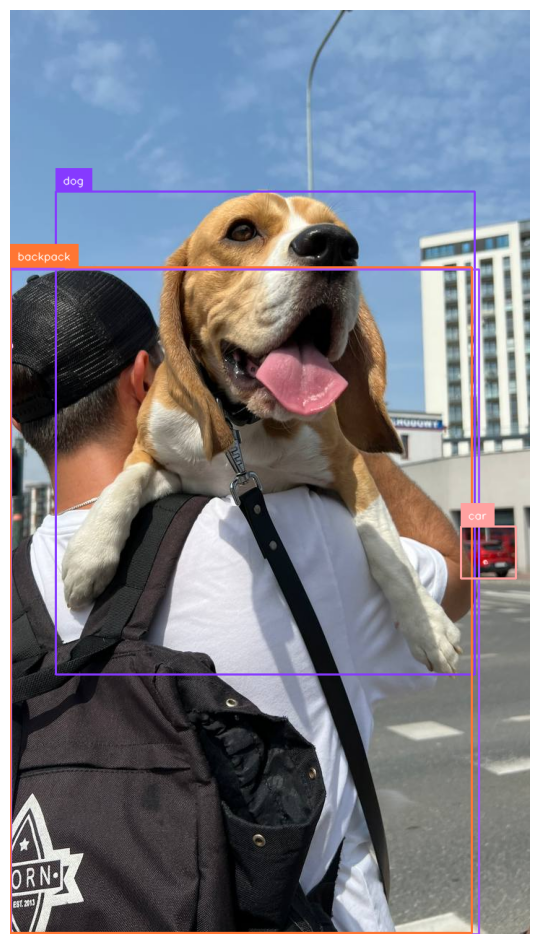

In [7]:
import cv2
from ultralytics import YOLO
import supervision as sv


image_path = f"{HOME}/dog.jpeg"
image = cv2.imread(image_path)

model = YOLO('yolov12n.pt')

results = model(image, verbose=False)[0]
detections = sv.Detections.from_ultralytics(results)

box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image = image.copy()
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)

## Download dataset from Roboflow Universe

In [8]:
from roboflow import download_dataset

dataset = download_dataset('https://universe.roboflow.com/ai-shop/retail-grocery-main4/dataset/2', 'yolov8')

loading Roboflow workspace...
loading Roboflow project...


In [9]:
!ls {dataset.location}

data.yaml  README.dataset.txt  README.roboflow.txt  test  train  valid


**NOTE:** We need to make a few changes to our downloaded dataset so it will work with YOLOv12. Run the following bash commands to prepare your dataset for training by updating the relative paths in the `data.yaml` file, ensuring it correctly points to the subdirectories for your dataset's `train`, `test`, and `valid` subsets.

In [10]:
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!echo -e "test: ../test/images\ntrain: ../train/images\nval: ../valid/images" >> {dataset.location}/data.yaml

In [11]:
!cat {dataset.location}/data.yaml

names:
- Abk Hell Beer
- Adnams Ghost Ship Beer
- Adnams Jack Brand Mosaic Beer
- Ahornberger Landbrauerei Marzen Beer
- Aldaris 1865 Beer
- Amstel Beer
- Amstel Premium Beer
- Amsterdam Navigator Beer
- Apostel Brau Beer
- Apples
- Arcobrau Mooser Liesl Beer
- Arcobrau Urfass Beer
- Asahi Super DRY Beer
- Augustijn Beer
- Bakalar Medovy Beer
- Balisto green
- Baltika -0 Beer
- Baltika -3 Beer
- Baltika -7 Beer
- Baltika -9 Beer
- Banana
- Bavaria Beer
- Bavaria Malt Non-Alcoholic Beer
- Bayreuther Hell Beer
- Belgian Kriek Beer
- Belhaven Black Scottish Stout Beer
- Belhaven McCallum-s Sweet Scottish Stout Beer
- Belle Vue Kriek Extra Beer
- Bely Medved Krepkoe Beer
- Benediktiner Hell Beer
- Berliner Kindl Jubilaums Pilsener Beer
- Bernard Cherny Lezak Beer
- Bernard Cvatecni Lezak Beer
- Bishops Finger Beer
- Bitburger Drive 0-0- Alkoholfreies Pils Beer
- Bitburger Premium Pils Beer
- Blanche De Namur Beer
- Blue Moon Beer
- Boddingtons Pub Ale Beer
- Bowler IPA Beer
- Brewdog Punk 

## Fine-tune YOLOv12 model

We are now ready to fine-tune our YOLOv12 model. In the code below, we initialize the model using a starting checkpoint—here, we use `yolov12s.yaml`, but you can replace it with any other model (e.g., `yolov12n.pt`, `yolov12m.pt`, `yolov12l.pt`, or `yolov12x.pt`) based on your preference. We set the training to run for 100 epochs in this example; however, you should adjust the number of epochs along with other hyperparameters such as batch size, image size, and augmentation settings (scale, mosaic, mixup, and copy-paste) based on your hardware capabilities and dataset size.

**Note:** **Note that after training, you might encounter a `TypeError: argument of type 'PosixPath' is not iterable error` — this is a known issue, but your model weights will still be saved, so you can safely proceed to running inference.**

In [12]:
from ultralytics import YOLO

model = YOLO('yolov12n.yaml')

results = model.train(data=f'{dataset.location}/data.yaml', epochs=11)

New https://pypi.org/project/ultralytics/8.3.155 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.63 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: task=detect, mode=train, model=yolov12n.yaml, data=/content/retail-grocery-main4-2/data.yaml, epochs=11, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train5, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, sho

train: Scanning /content/retail-grocery-main4-2/train/labels.cache... 90690 images, 18121 backgrounds, 0 corrupt: 100%|██████████| 90690/90690 [00:00<?, ?it/s]


WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 4262, len(boxes) = 116915. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


Argument(s) 'quality_lower' are not valid for transform ImageCompression
val: Scanning /content/retail-grocery-main4-2/valid/labels.cache... 2745 images, 514 backgrounds, 0 corrupt: 100%|██████████| 2745/2745 [00:00<?, ?it/s]

WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 36, len(boxes) = 3427. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.


Plotting labels to runs/detect/train5/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 121 weight(decay=0.0), 128 weight(decay=0.0005), 127 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train5
Starting training for 11 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/11      5.09G      2.778      6.324      3.702          4        640: 100%|██████████| 5669/5669 [26:04<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 86/86 [00:21<00:00,  3.96it/s]


                   all       2745       3427      0.454      0.028     0.0172    0.00961
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


Argument(s) 'quality_lower' are not valid for transform ImageCompression



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/11      5.12G      1.485      5.153      2.232          7        640: 100%|██████████| 5669/5669 [25:13<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 86/86 [00:21<00:00,  4.04it/s]


                   all       2745       3427      0.651     0.0742     0.0991     0.0741

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/11      5.13G      1.347      3.702      1.964          2        640: 100%|██████████| 5669/5669 [24:51<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 86/86 [00:21<00:00,  3.98it/s]


                   all       2745       3427      0.702      0.112       0.15      0.112

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/11      5.13G       1.27      2.857      1.826          1        640: 100%|██████████| 5669/5669 [24:48<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 86/86 [00:21<00:00,  4.01it/s]


                   all       2745       3427      0.736      0.141      0.185      0.142

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/11      5.13G      1.174      2.401      1.715          9        640: 100%|██████████| 5669/5669 [24:45<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 86/86 [00:21<00:00,  4.08it/s]


                   all       2745       3427      0.749      0.163      0.227      0.175

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/11      5.11G      1.106       2.11      1.638          5        640: 100%|██████████| 5669/5669 [24:31<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 86/86 [00:21<00:00,  4.09it/s]


                   all       2745       3427      0.742      0.198      0.267      0.206

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/11      5.12G      1.053      1.897      1.585          4        640: 100%|██████████| 5669/5669 [24:29<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 86/86 [00:20<00:00,  4.11it/s]


                   all       2745       3427      0.784      0.198      0.279      0.216

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/11      5.12G      1.014      1.723      1.543          2        640: 100%|██████████| 5669/5669 [24:34<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 86/86 [00:20<00:00,  4.11it/s]


                   all       2745       3427      0.644       0.25      0.296      0.229

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/11      5.12G     0.9679      1.573      1.502          1        640: 100%|██████████| 5669/5669 [24:32<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 86/86 [00:21<00:00,  4.06it/s]


                   all       2745       3427      0.657      0.254      0.308      0.238

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/11      5.11G      0.931      1.444      1.468          2        640: 100%|██████████| 5669/5669 [24:30<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 86/86 [00:20<00:00,  4.10it/s]


                   all       2745       3427      0.652      0.265      0.317      0.246

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/11      5.13G     0.8992      1.324      1.439         11        640: 100%|██████████| 5669/5669 [24:34<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 86/86 [00:20<00:00,  4.10it/s]


                   all       2745       3427      0.634       0.27      0.323      0.251

11 epochs completed in 4.620 hours.
Optimizer stripped from runs/detect/train5/weights/last.pt, 5.8MB
Optimizer stripped from runs/detect/train5/weights/best.pt, 5.8MB

Validating runs/detect/train5/weights/best.pt...
Ultralytics 8.3.63 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
YOLOv12n summary (fused): 376 layers, 2,659,832 parameters, 0 gradients, 6.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 86/86 [00:16<00:00,  5.30it/s]


                   all       2745       3427      0.634       0.27      0.323      0.251
         Abk Hell Beer          5          5          0          0          0          0
Adnams Ghost Ship Beer          6          6          1          0      0.021     0.0168
Adnams Jack Brand Mosaic Beer          5          5          1          0          0          0
Ahornberger Landbrauerei Marzen Beer          6          6          1          0          0          0
     Aldaris 1865 Beer          2          2          1          0          0          0
           Amstel Beer          6          6          1          0          0          0
   Amstel Premium Beer          3          3          1          0     0.0234     0.0187
                Apples          4          4      0.221       0.75      0.657      0.467
Arcobrau Mooser Liesl Beer          1          1          0          0          0          0
  Asahi Super DRY Beer          1          1          0          0     0.0269     0.0

## Evaluate fine-tuned YOLOv12 model

In [13]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!ls {HOME}/runs/detect/train5/

args.yaml					     train_batch1.jpg
confusion_matrix_normalized.png			     train_batch2.jpg
confusion_matrix.png				     train_batch5669.jpg
events.out.tfevents.1750073548.2edb9bdaa420.12126.0  train_batch5670.jpg
F1_curve.png					     train_batch5671.jpg
labels_correlogram.jpg				     val_batch0_labels.jpg
labels.jpg					     val_batch0_pred.jpg
P_curve.png					     val_batch1_labels.jpg
PR_curve.png					     val_batch1_pred.jpg
R_curve.png					     val_batch2_labels.jpg
results.csv					     val_batch2_pred.jpg
results.png					     weights
train_batch0.jpg


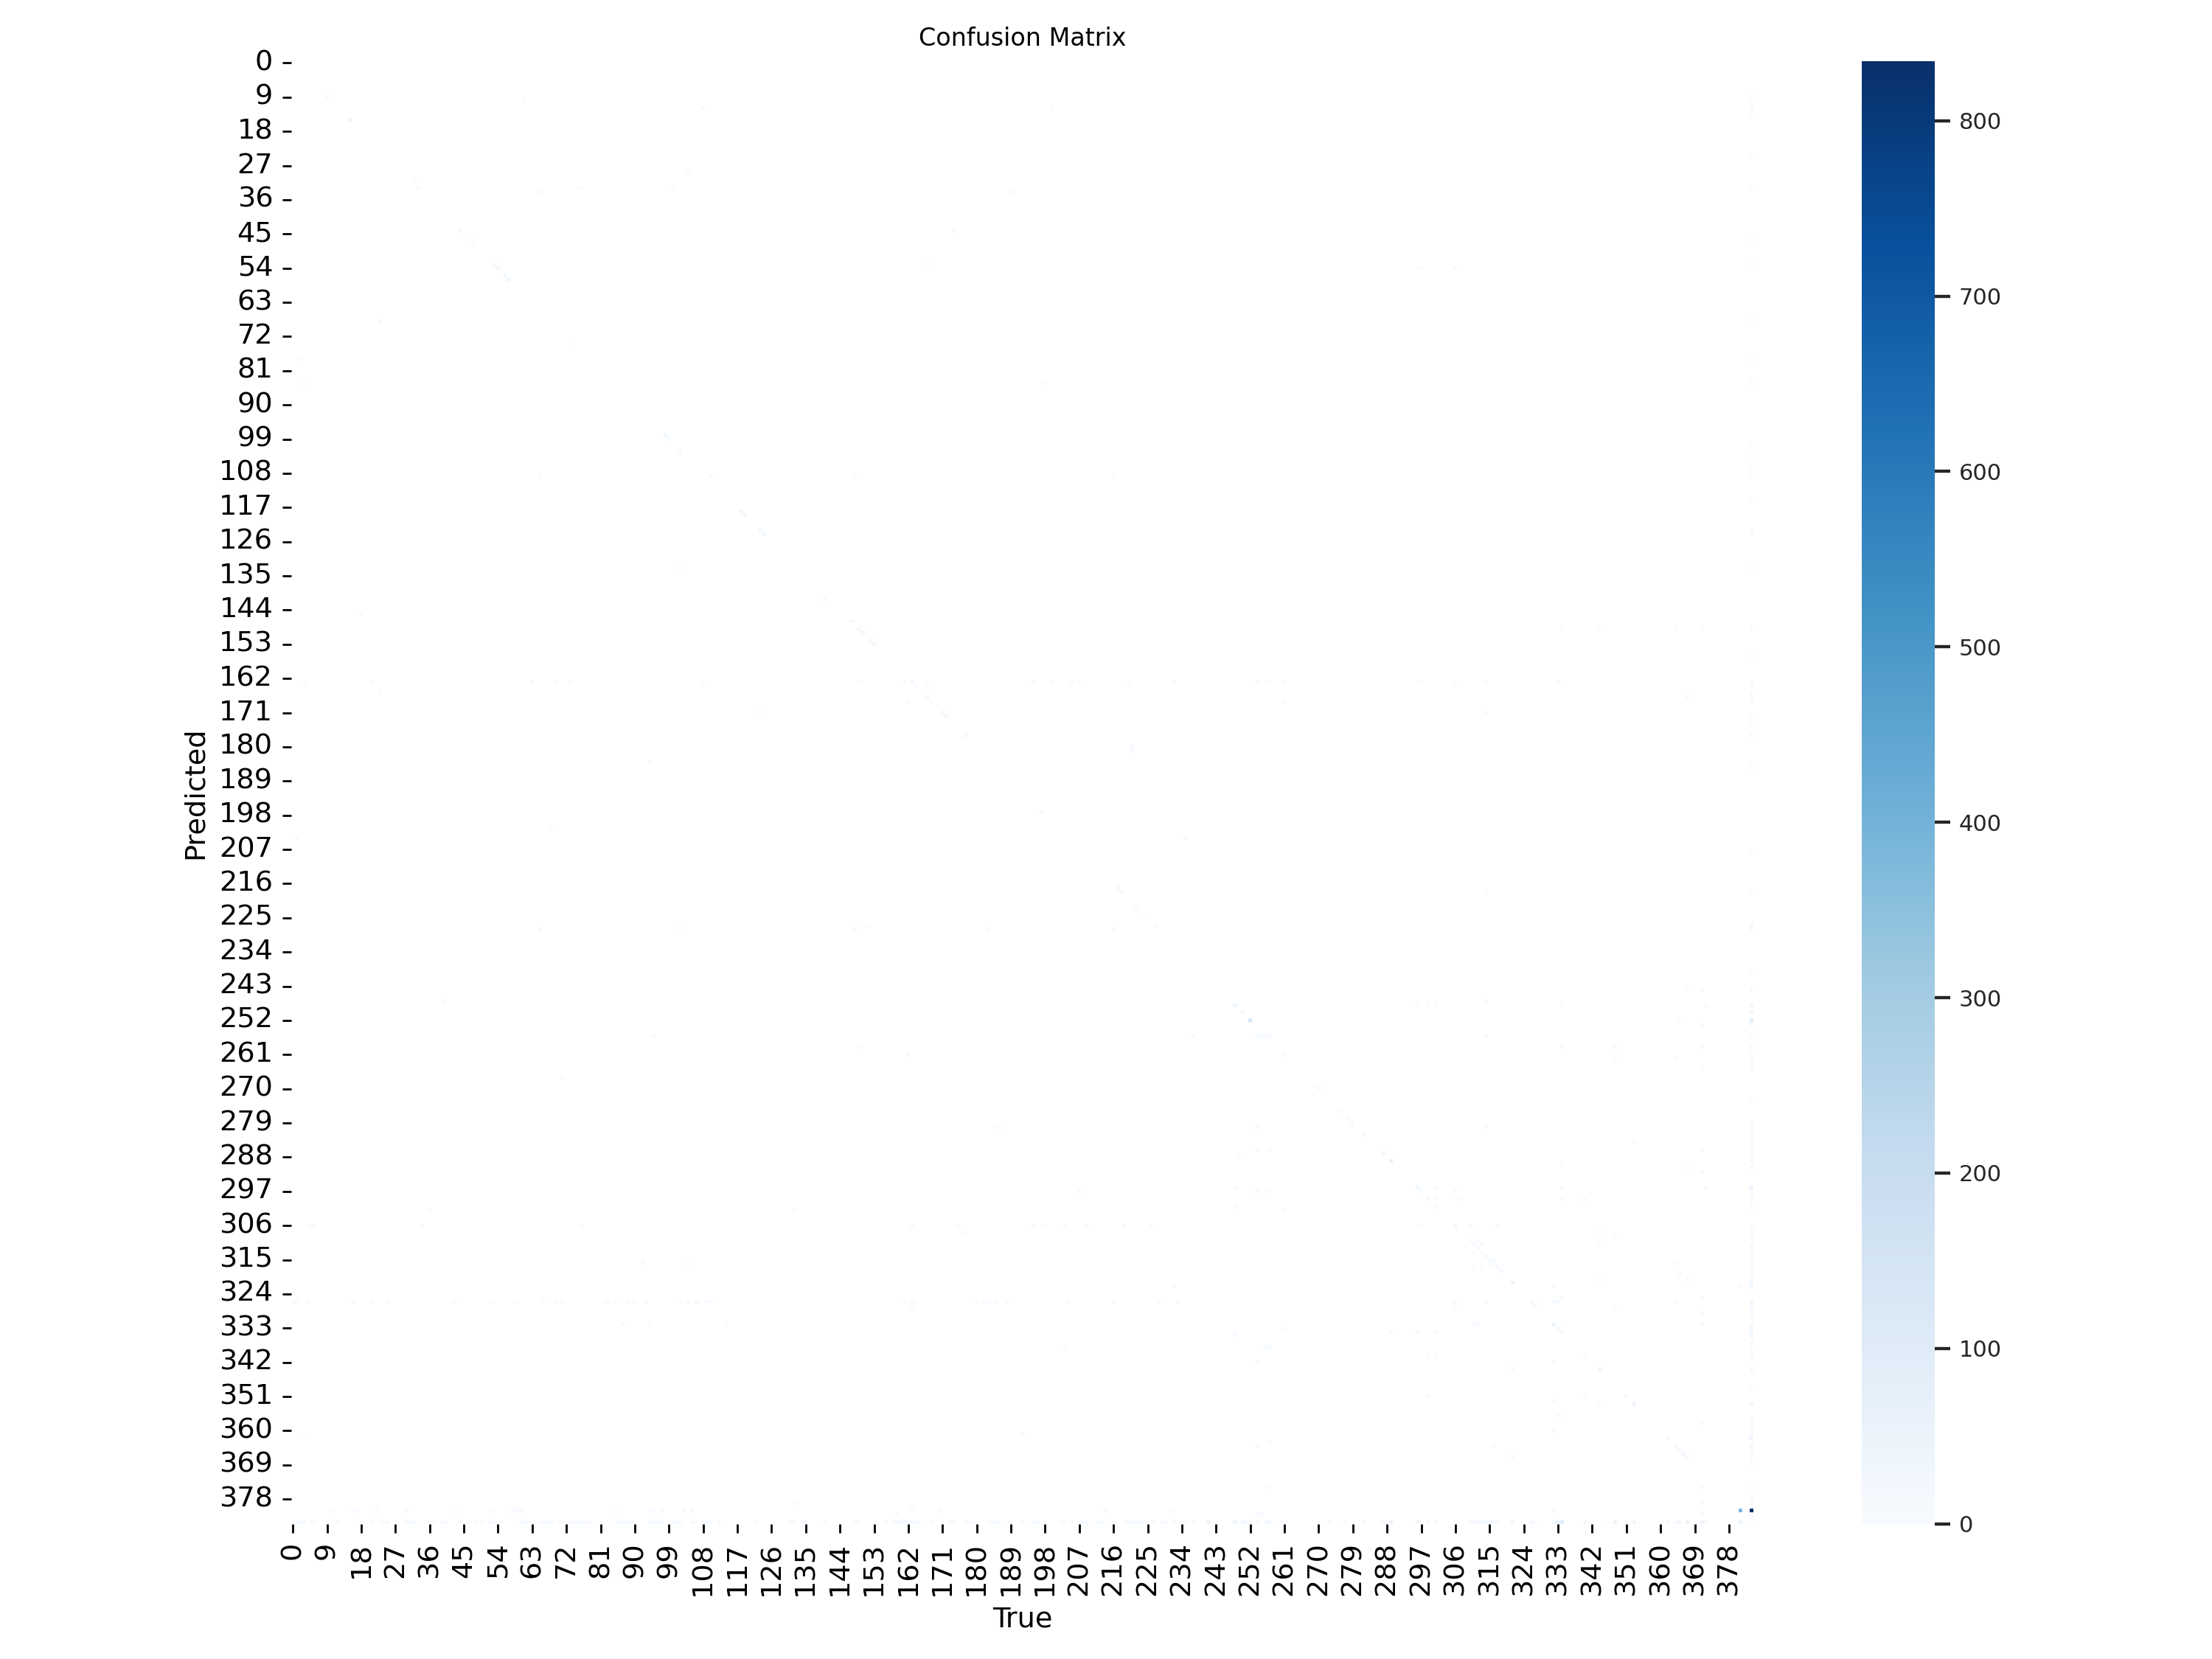

In [14]:
from IPython.display import Image

Image(filename=f'{HOME}/runs/detect/train5/confusion_matrix.png', width=1000)

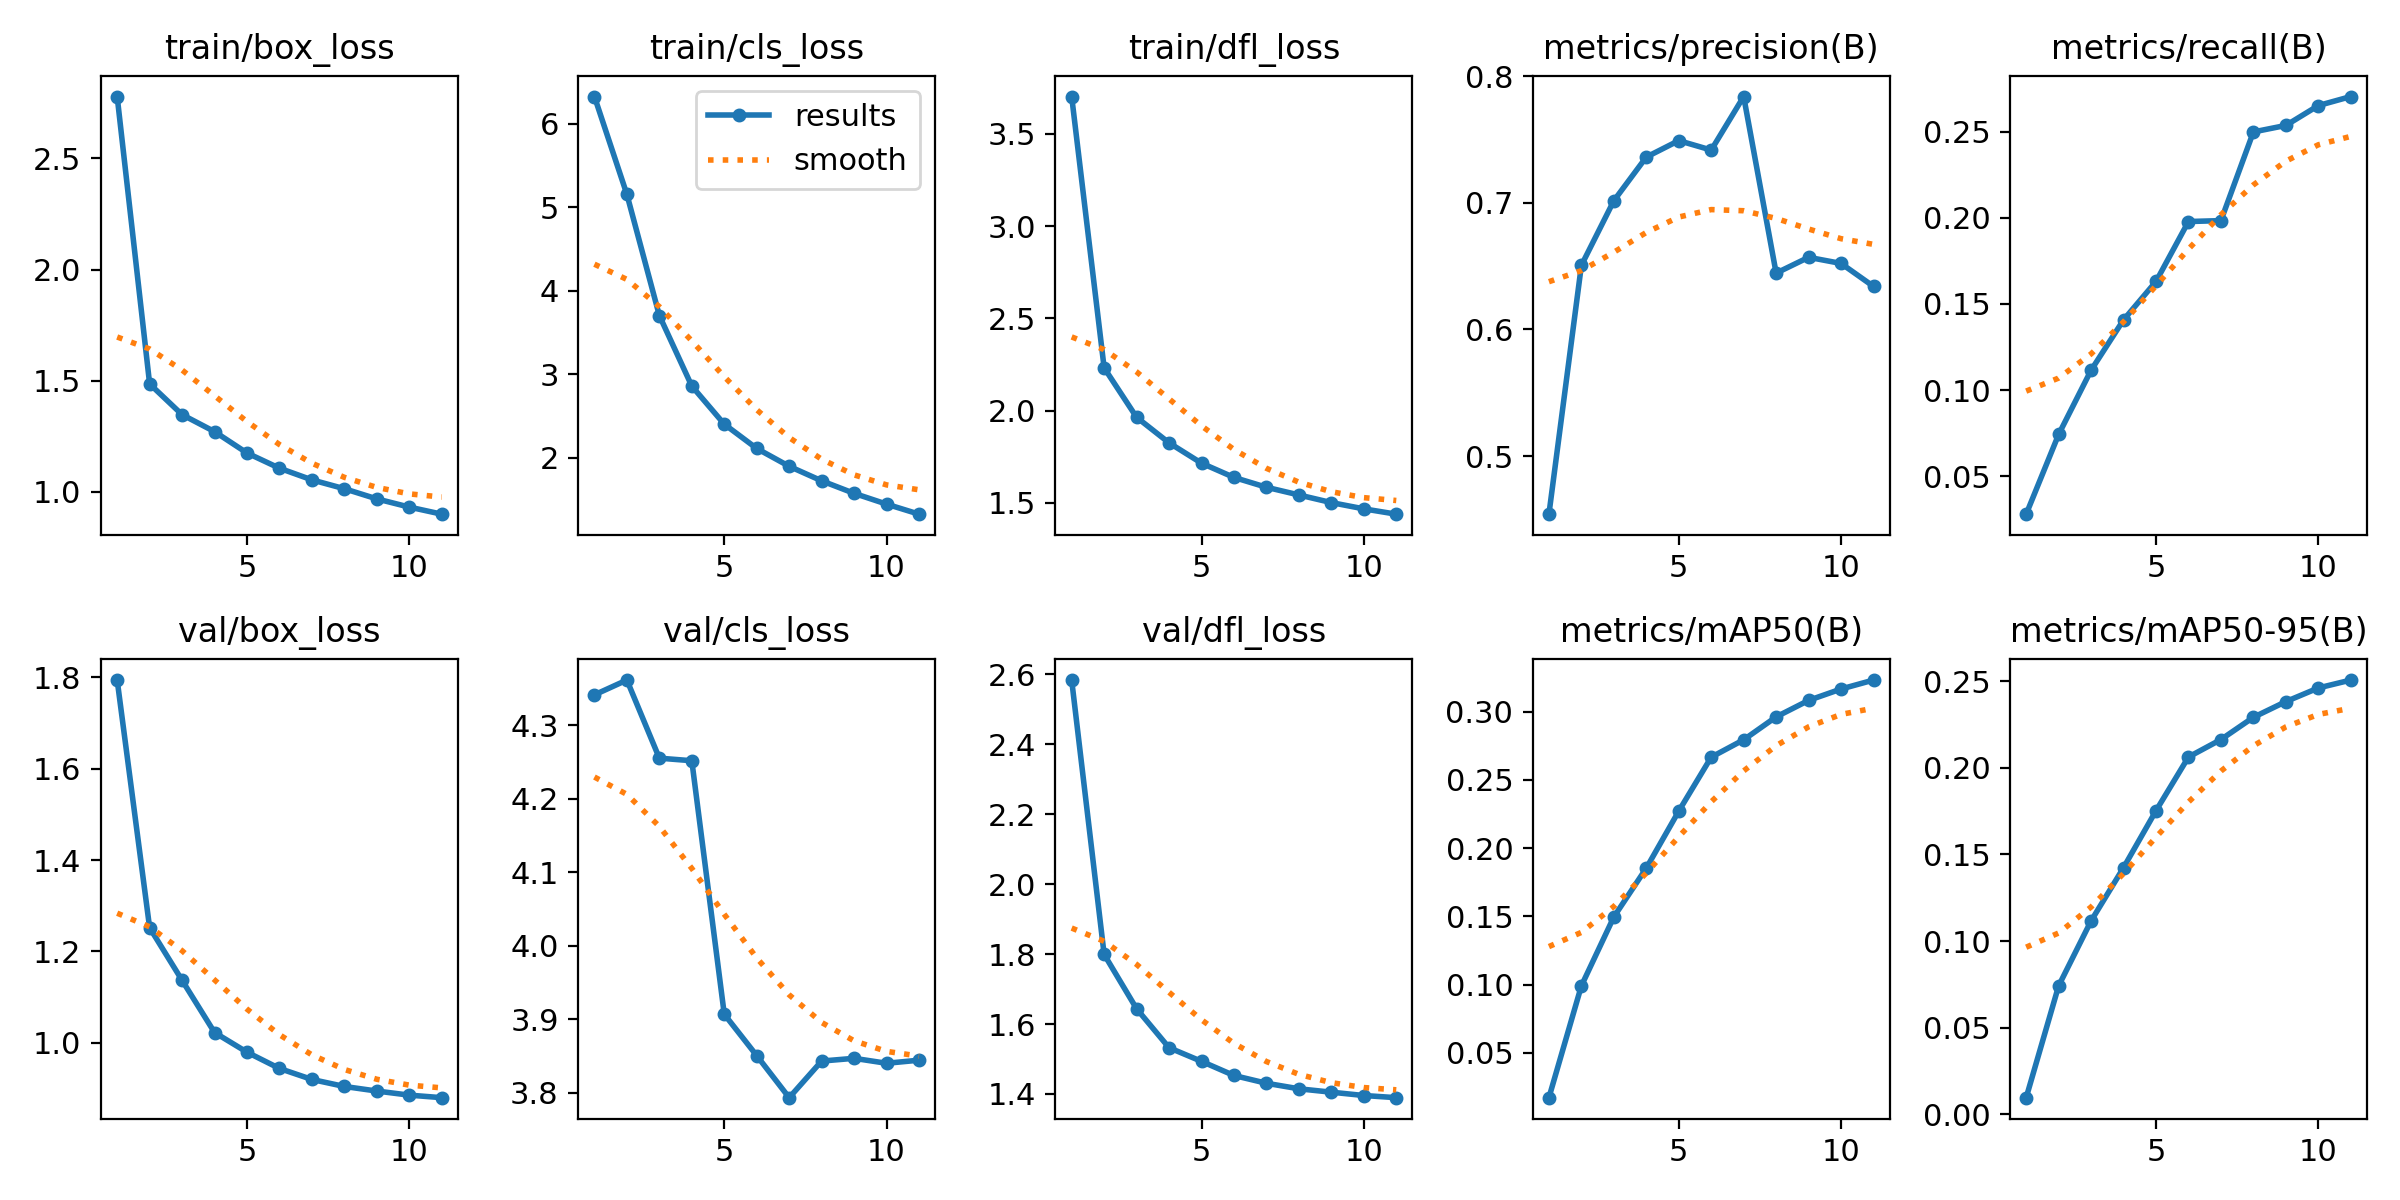

In [15]:
from IPython.display import Image

Image(filename=f'{HOME}/runs/detect/train5/results.png', width=1000)

In [16]:
import supervision as sv

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/test/images",
    annotations_directory_path=f"{dataset.location}/test/labels",
    data_yaml_path=f"{dataset.location}/data.yaml"
)

ds.classes

['Abk Hell Beer',
 'Adnams Ghost Ship Beer',
 'Adnams Jack Brand Mosaic Beer',
 'Ahornberger Landbrauerei Marzen Beer',
 'Aldaris 1865 Beer',
 'Amstel Beer',
 'Amstel Premium Beer',
 'Amsterdam Navigator Beer',
 'Apostel Brau Beer',
 'Apples',
 'Arcobrau Mooser Liesl Beer',
 'Arcobrau Urfass Beer',
 'Asahi Super DRY Beer',
 'Augustijn Beer',
 'Bakalar Medovy Beer',
 'Balisto green',
 'Baltika -0 Beer',
 'Baltika -3 Beer',
 'Baltika -7 Beer',
 'Baltika -9 Beer',
 'Banana',
 'Bavaria Beer',
 'Bavaria Malt Non-Alcoholic Beer',
 'Bayreuther Hell Beer',
 'Belgian Kriek Beer',
 'Belhaven Black Scottish Stout Beer',
 'Belhaven McCallum-s Sweet Scottish Stout Beer',
 'Belle Vue Kriek Extra Beer',
 'Bely Medved Krepkoe Beer',
 'Benediktiner Hell Beer',
 'Berliner Kindl Jubilaums Pilsener Beer',
 'Bernard Cherny Lezak Beer',
 'Bernard Cvatecni Lezak Beer',
 'Bishops Finger Beer',
 'Bitburger Drive 0-0- Alkoholfreies Pils Beer',
 'Bitburger Premium Pils Beer',
 'Blanche De Namur Beer',
 'Blue Moo

In [18]:
from supervision.metrics import MeanAveragePrecision

model = YOLO(f'/{HOME}/runs/detect/train5/weights/best.pt')

predictions = []
targets = []

for _, image, target in ds:
    results = model(image, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(results)

    predictions.append(detections)
    targets.append(target)

map = MeanAveragePrecision().update(predictions, targets).compute()

In [19]:
print("mAP 50:95", map.map50_95)
print("mAP 50", map.map50)
print("mAP 75", map.map75)

mAP 50:95 0.39288126600611717
mAP 50 0.49375625524654587
mAP 75 0.4392430519903976


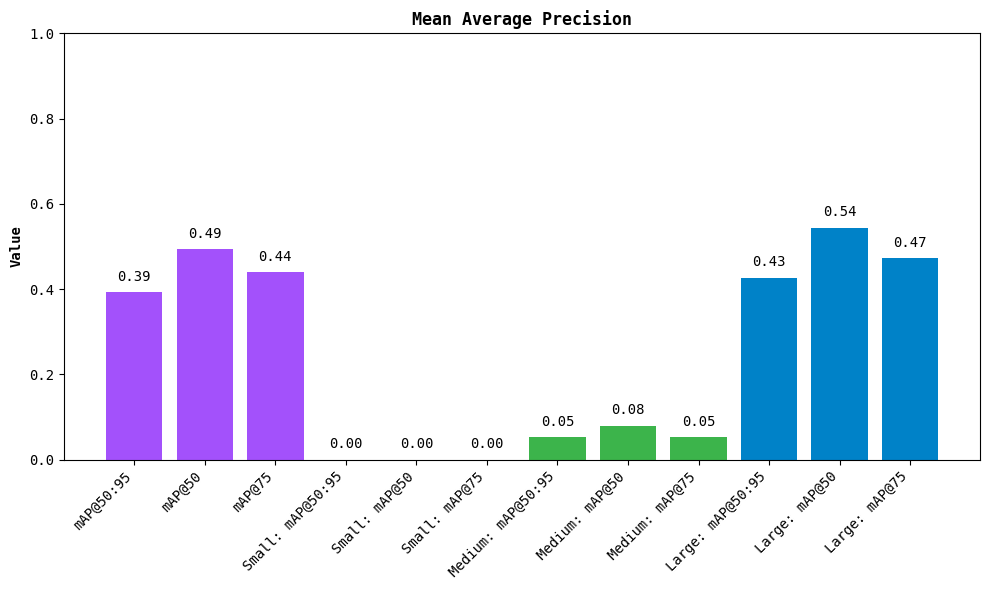

In [20]:
map.plot()

## Run inference with fine-tuned YOLOv12 model

In [21]:
import supervision as sv

model = YOLO(f'/{HOME}/runs/detect/train5/weights/best.pt')

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/test/images",
    annotations_directory_path=f"{dataset.location}/test/labels",
    data_yaml_path=f"{dataset.location}/data.yaml"
)

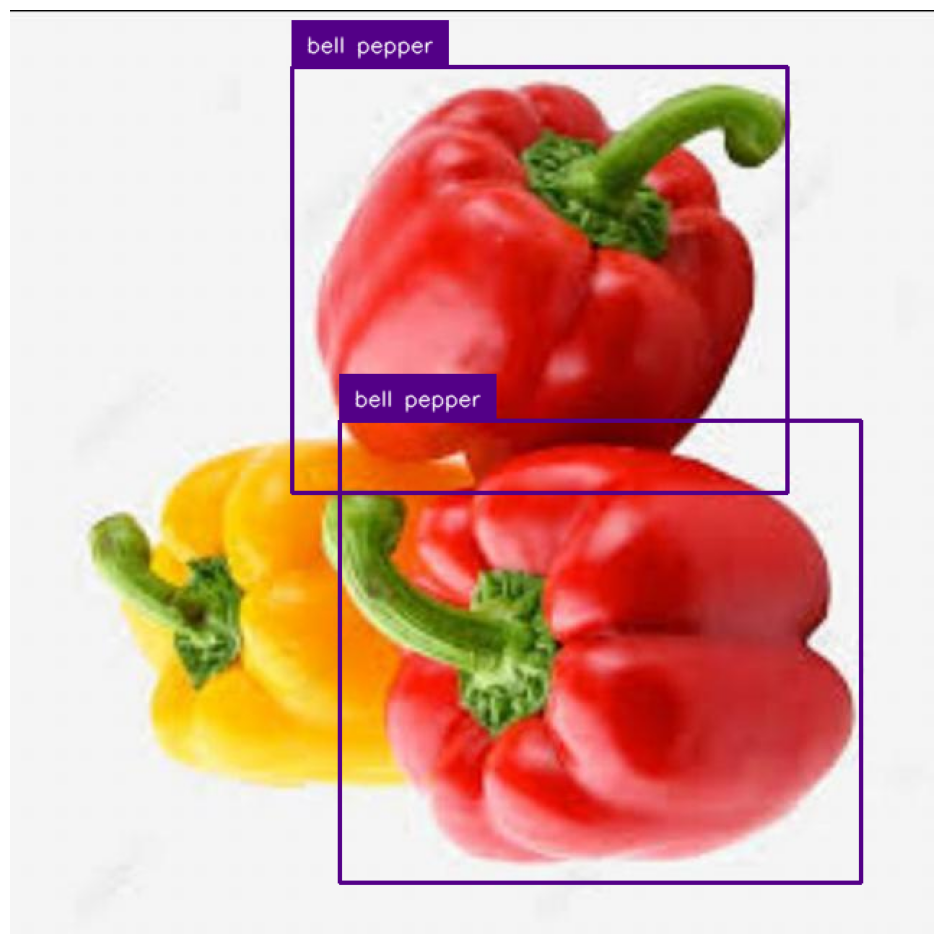

In [23]:
import random

i = random.randint(0, len(ds))

image_path, image, target = ds[i]

results = model(image, verbose=False)[0]
detections = sv.Detections.from_ultralytics(results).with_nms()

box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image = image.copy()
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)